In [1]:
import json
from collections import defaultdict, Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from tqdm import tqdm
import csv
import re
import string

In [2]:
ROOT = '/data0/lucy/language-map-of-science/'
LOGS = ROOT + 'logs/'
DATA = ROOT + 'data/'

In [3]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

## Overall jargon rate discipline specific vs. general purpose

In [36]:
journal_df = pd.read_csv(DATA + 'input_paper_ids/journal_df.csv', index_col=0)

In [37]:
with open(LOGS + 'general_specific/single_discp_journals.json', 'r') as infile: 
    single_discp_dict = json.load(infile)

In [38]:
multi_journals = ['national science review', 'nature', 'nature communications', 
                'philosophical transactions of the royal society a', 'plos one', 
                'proceedings of the national academy of sciences', 'proceedings of the royal society a', 
                'science', 'science advances', 'scientific reports'] 

In [39]:
multi_df = journal_df[journal_df['clean journal/venue'].isin(multi_journals)]
multi_paper_ids = multi_df.groupby('clean journal/venue')['paper id'].apply(set).to_dict()
paper_ids_multi = {} # {paper : journal}
for journal in multi_paper_ids:
    for paper_id in multi_paper_ids[journal]: 
        paper_ids_multi[str(paper_id)] = journal

In [40]:
with open(LOGS + 'general_specific/papers_of_interest.json', 'r') as infile: 
    general_specific_papers = json.load(infile)

In [41]:
paper_type = {} # {paper: journal type}
paper_discp = {} # {paper: discipline}
for key in general_specific_papers: 
    for journal in tqdm(general_specific_papers[key]): 
        tups = general_specific_papers[key][journal]
        for tup in tups: 
            paper_discp[str(tup[0])] = tup[1]
            paper_type[str(tup[0])] = key

100%|██████████| 6/6 [00:00<00:00, 1536.38it/s]


In [42]:
level_to_topics = defaultdict(set)
with open(DATA + 'fos_level.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader: 
        level_to_topics[row['level']].add(row['displayname'].lower())
child_to_parents = defaultdict(set)
with open(DATA + 'mag_parent_child.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader: 
        if row['parent_display_name'].lower() in level_to_topics['0']: 
            if row['child_display_name'].lower() in level_to_topics['1']: 
                child_to_parents[row['child_display_name'].lower()].add(row['parent_display_name'].lower())

In [43]:
paper_scores_path = LOGS + 'general_specific/paper_scores/'

In [44]:
result = {
    'cutoff': [], 
    'journal type': [], # discipline specific or general purpose
    'fos': [], 
    'prop': [], 
    'journal': [], # discipline specific or title of general purpose
}
for cutoff in os.listdir(paper_scores_path): 
    infolder = os.path.join(paper_scores_path, cutoff)
    for f in tqdm(os.listdir(infolder)): 
        with open(os.path.join(infolder, f), 'r') as infile: 
            d = json.load(infile)
        for paper_id in d: 
            for fos in child_to_parents[paper_discp[paper_id]]: 
                result['prop'].append(d[paper_id]['sense'] + d[paper_id]['type'])
                result['cutoff'].append(cutoff)
                result['fos'].append(fos.replace('science', 'sci.'))
                result['journal type'].append(paper_type[paper_id])
                if paper_type[paper_id] == 'single': 
                    result['journal'].append(paper_type[paper_id])
                else: 
                    result['journal'].append(paper_ids_multi[paper_id])
            
result_df = pd.DataFrame(data=result)
result_df

100%|██████████| 100/100 [00:02<00:00, 35.62it/s]


,cutoff,journal type,fos,prop,journal
0,0.1,single,medicine,0.363636,single
1,0.1,single,biology,0.172043,single
2,0.1,single,mathematics,0.459016,single
3,0.1,single,sociology,0.134615,single
4,0.1,single,medicine,0.373832,single
...,...,...,...,...,...
655279,0.2,single,engineering,0.147541,single
655280,0.2,single,medicine,0.195122,single
655281,0.2,single,biology,0.195122,single
655282,0.2,single,mathematics,0.025000,single


In [45]:
# filter to the top FOS that show up in multidisciplinary journals
this_df = result_df[result_df['cutoff'] == '0.1']
this_df = this_df[this_df['journal type'] == 'multi']
topNfos_multi = [tup[0] for tup in Counter(this_df['fos'].to_list()).most_common(100)]
this_df = result_df[result_df['cutoff'] == '0.1']
this_df = this_df[this_df['journal type'] == 'single']
topNfos_single = [tup[0] for tup in Counter(this_df['fos'].to_list()).most_common(100)]
topNfos = set(topNfos_multi) & set(topNfos_single)
print(topNfos)
topNfos_df = result_df[result_df['fos'].isin(set(topNfos))]
topNfos_df

{'psychology', 'economics', 'art', 'physics', 'biology', 'political sci.', 'history', 'computer sci.', 'materials sci.', 'sociology', 'medicine', 'geology', 'engineering', 'geography', 'mathematics', 'chemistry', 'environmental sci.', 'philosophy', 'business'}


,cutoff,journal type,fos,prop,journal
0,0.1,single,medicine,0.363636,single
1,0.1,single,biology,0.172043,single
2,0.1,single,mathematics,0.459016,single
3,0.1,single,sociology,0.134615,single
4,0.1,single,medicine,0.373832,single
...,...,...,...,...,...
655279,0.2,single,engineering,0.147541,single
655280,0.2,single,medicine,0.195122,single
655281,0.2,single,biology,0.195122,single
655282,0.2,single,mathematics,0.025000,single


0.1


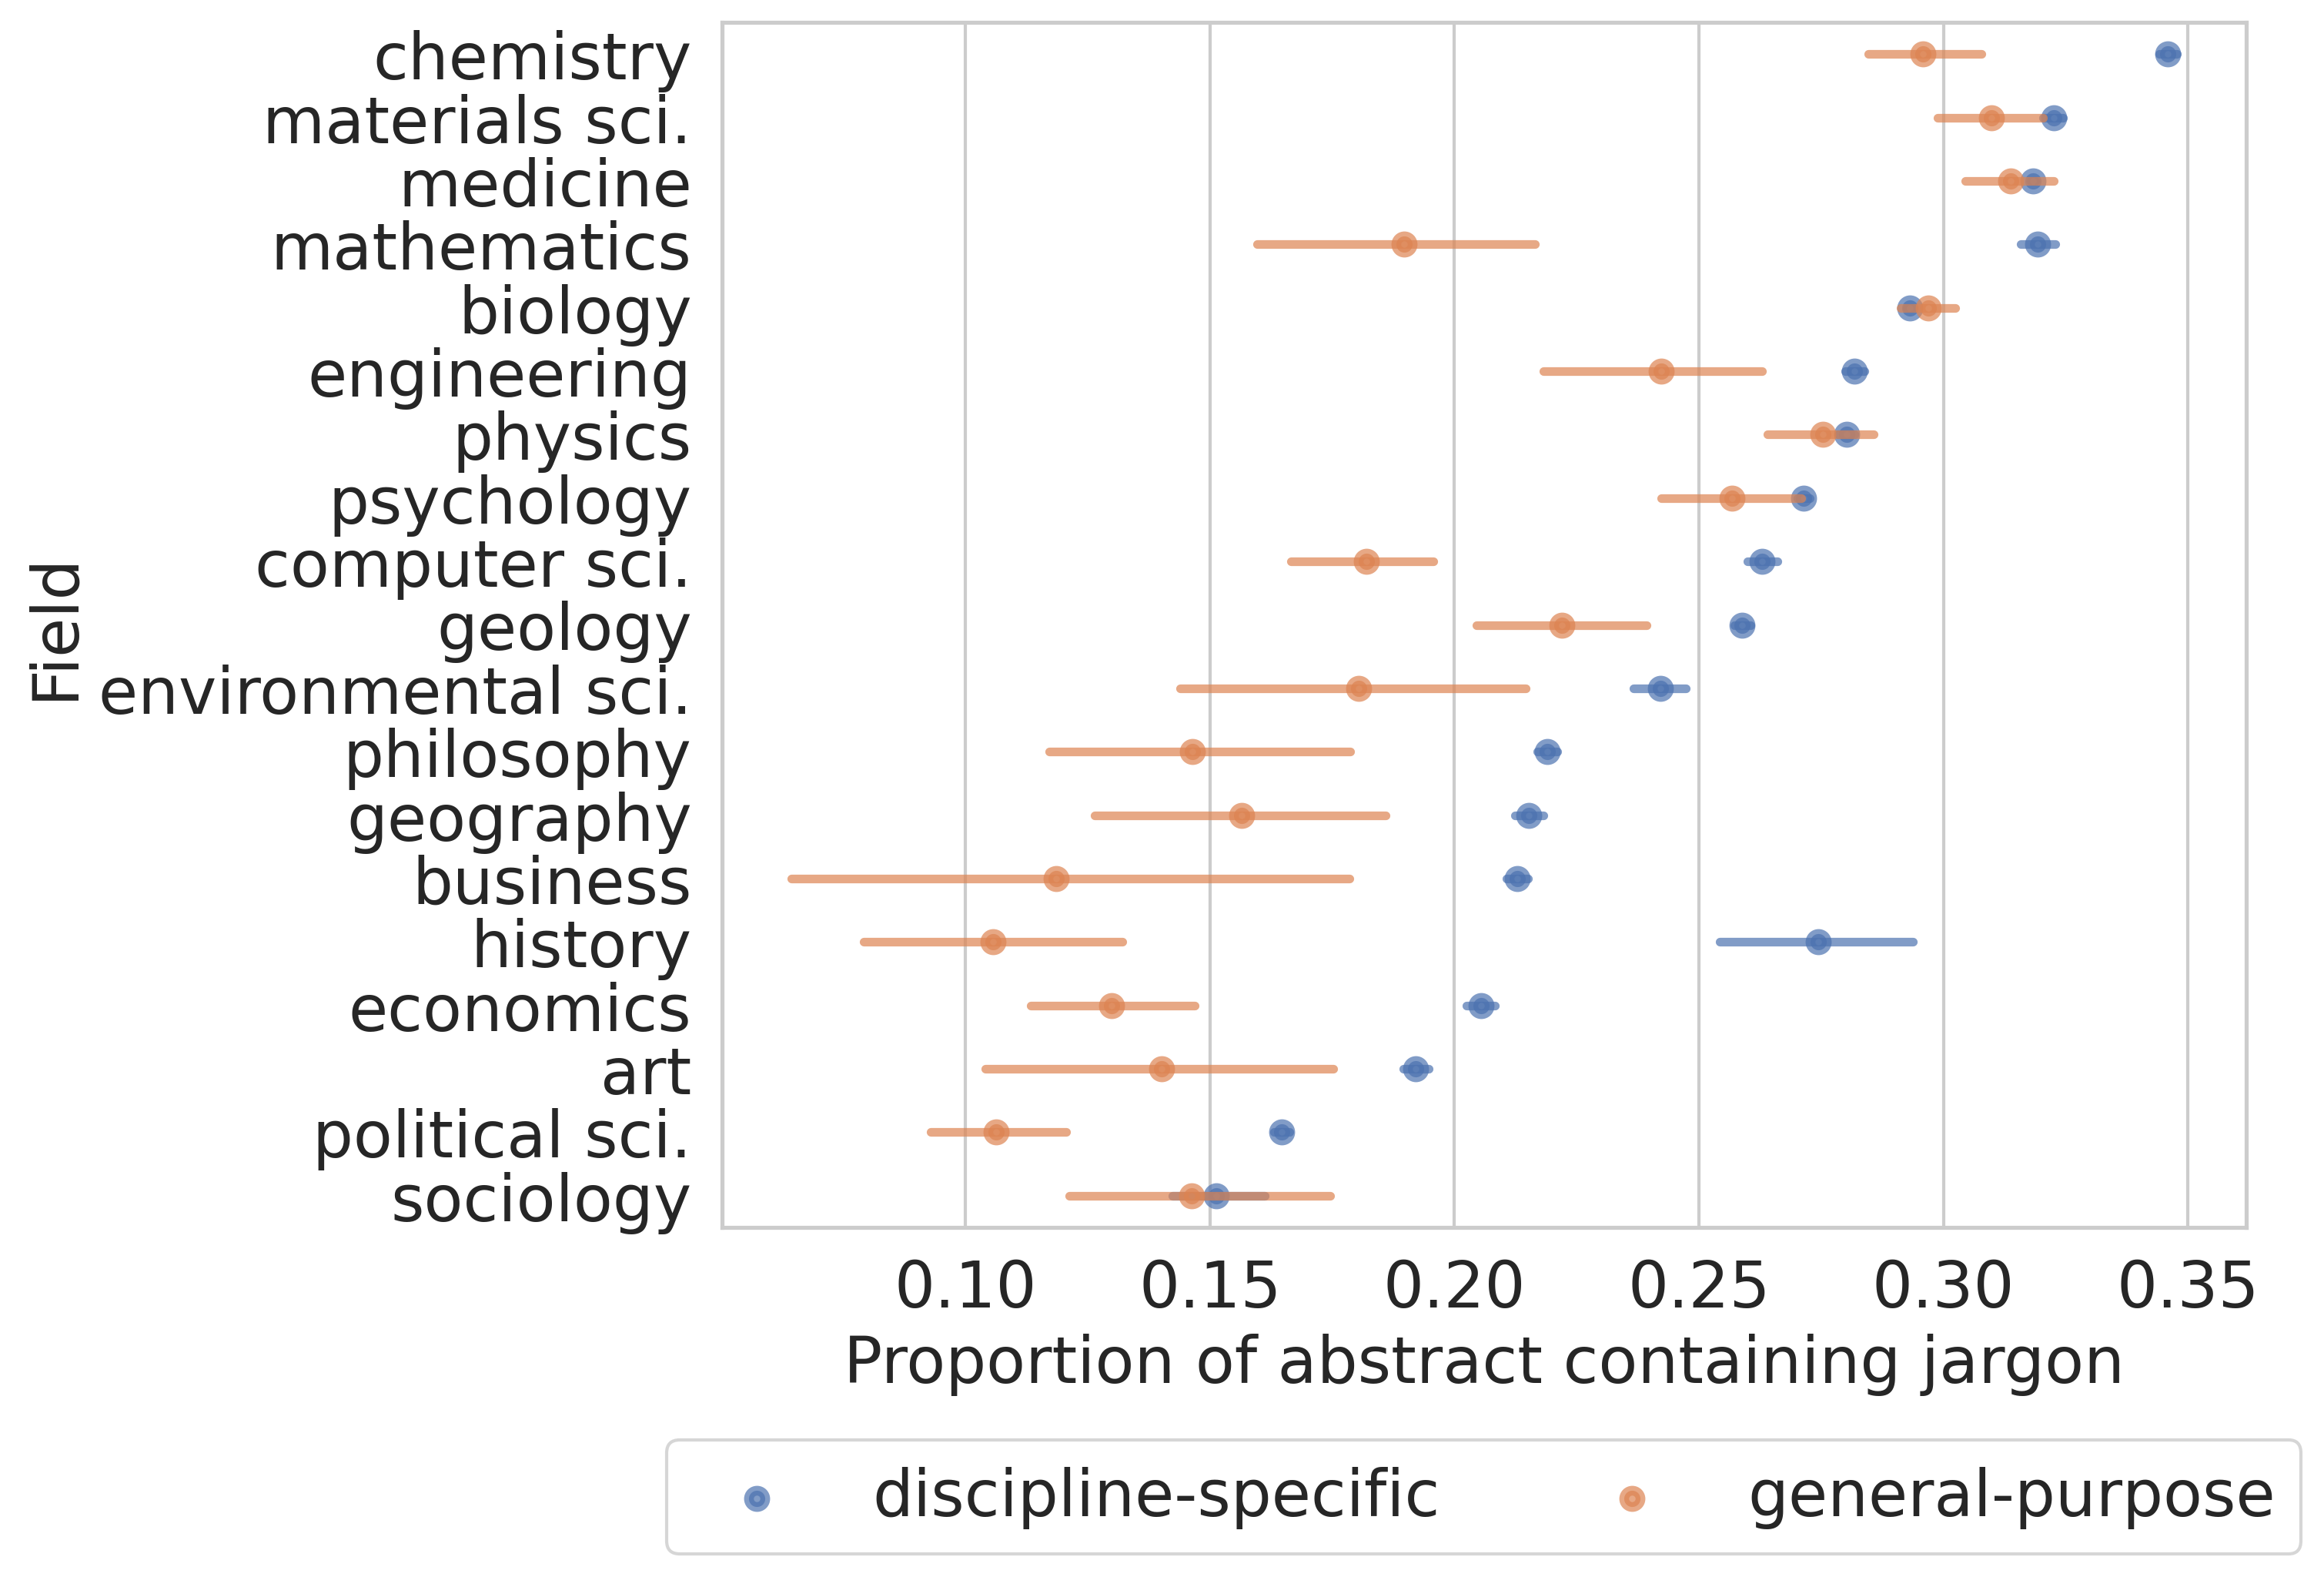

0.2


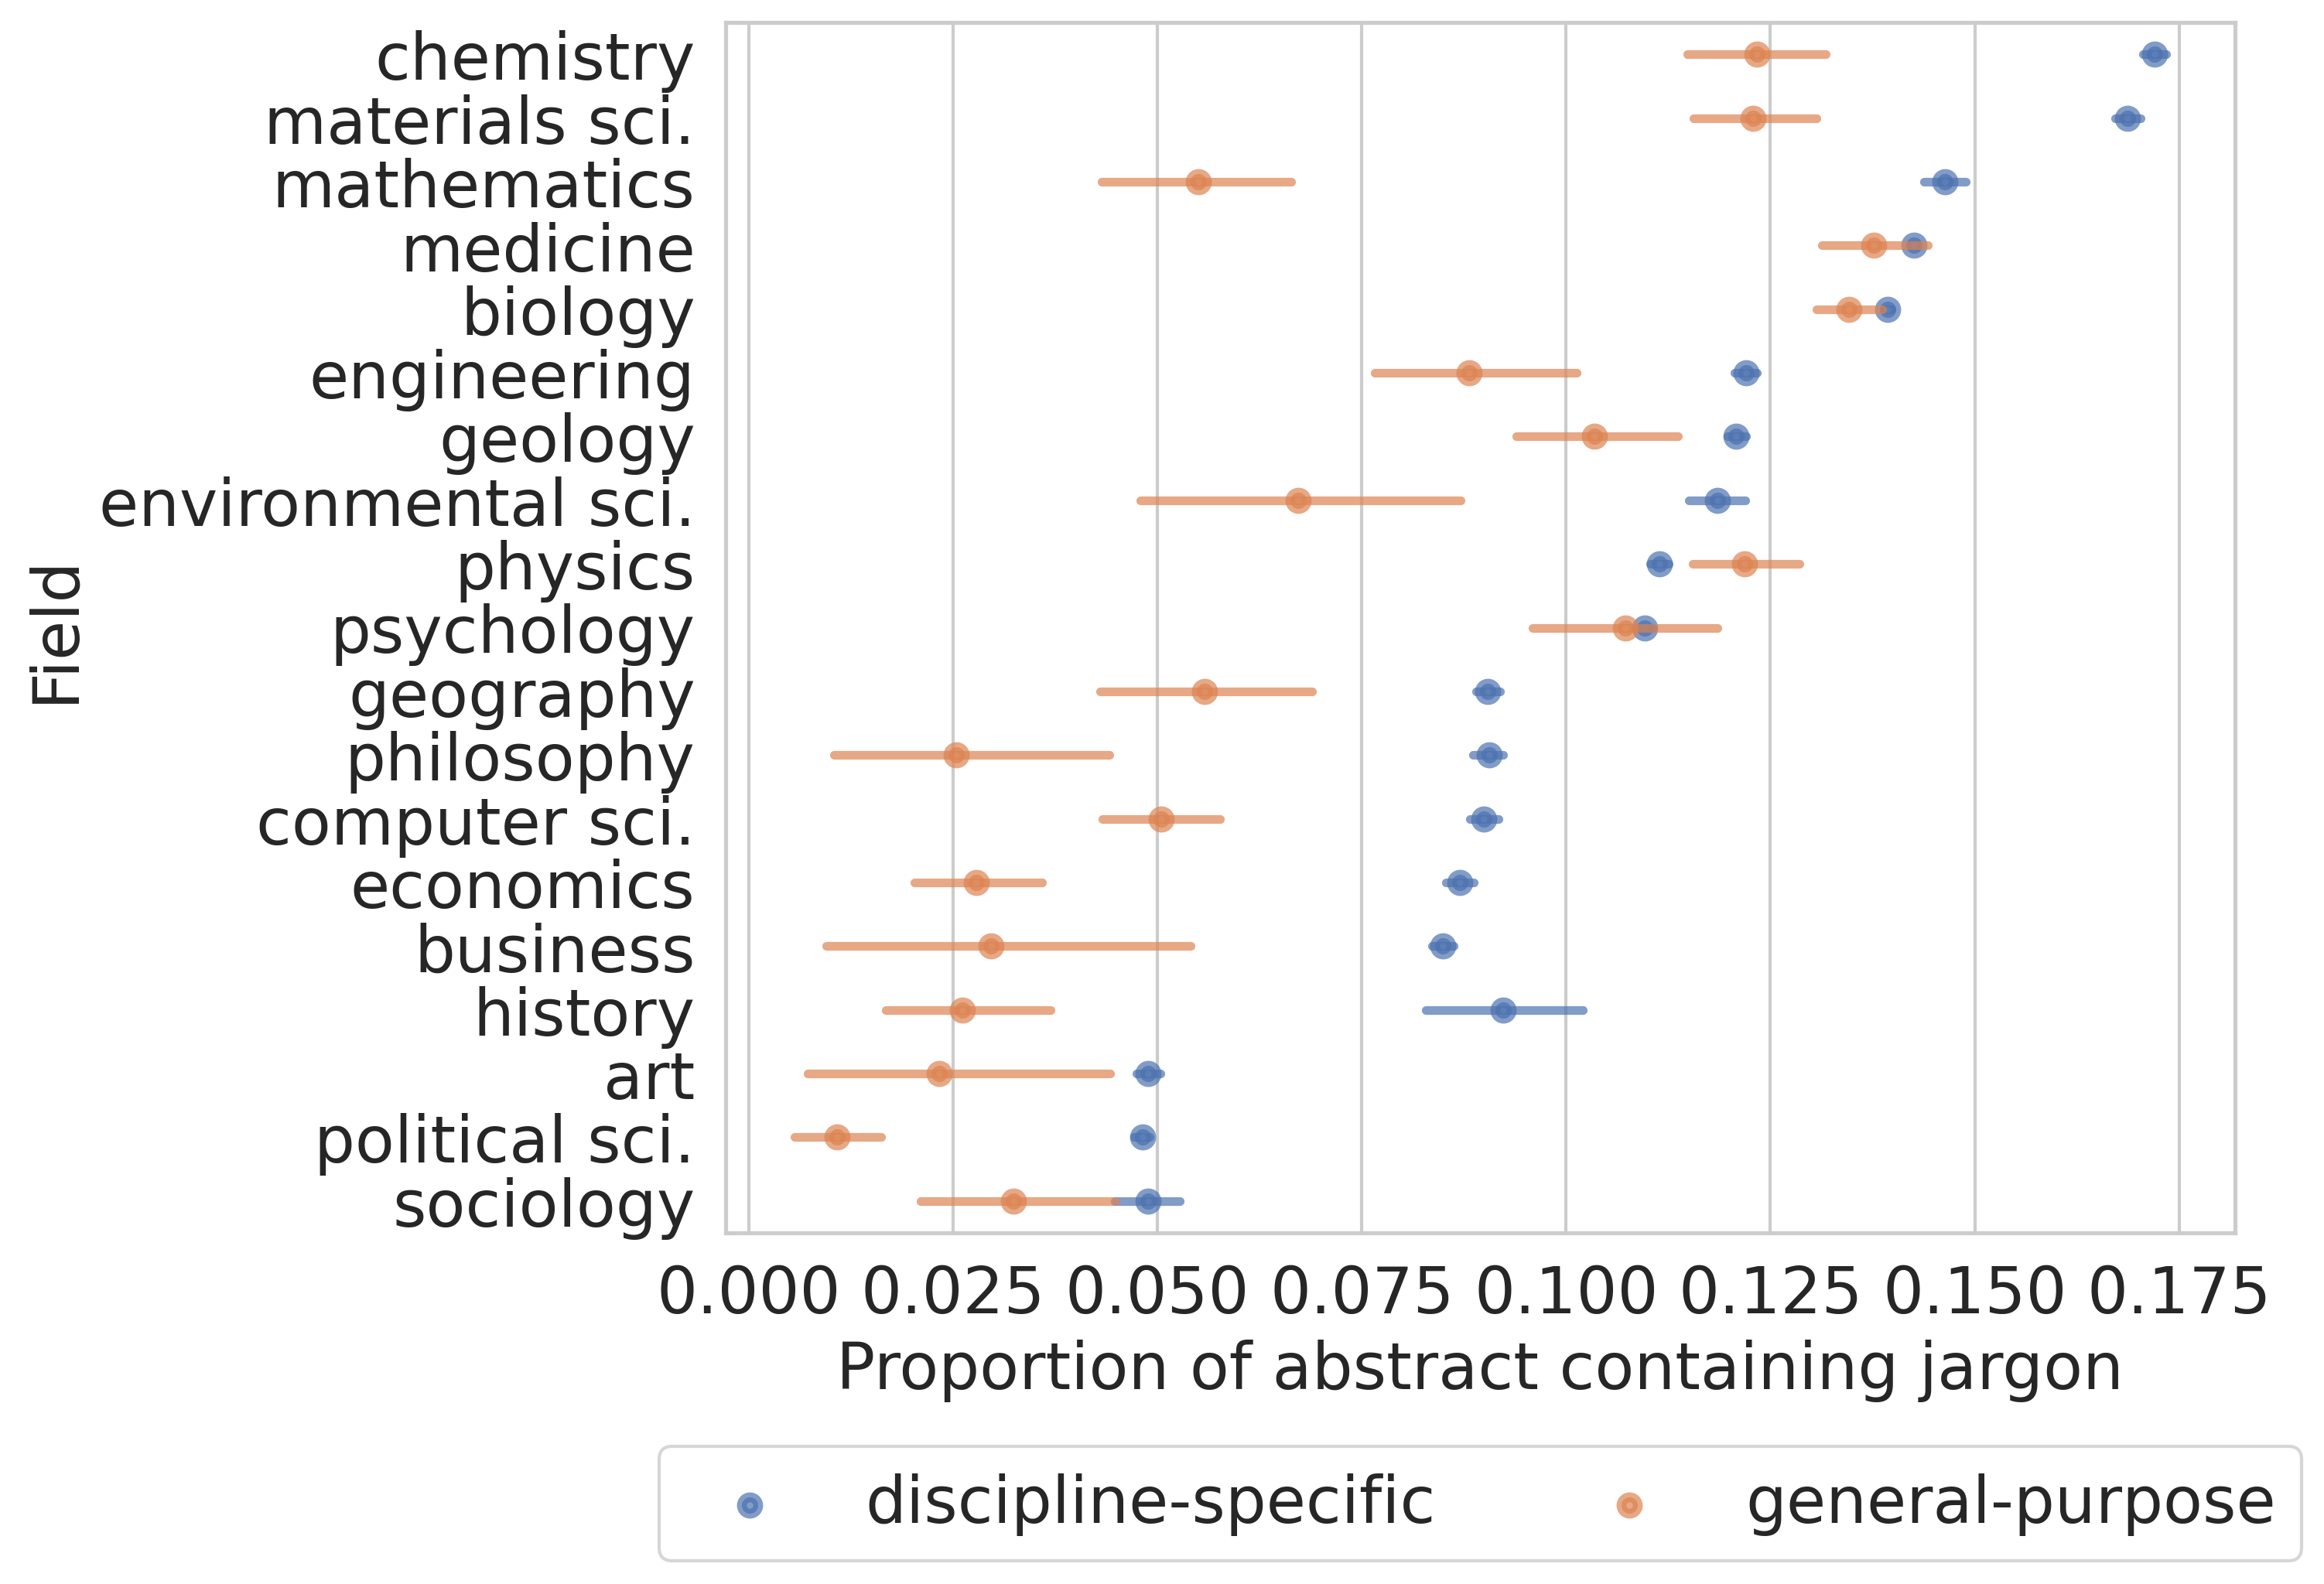

In [46]:
sns.set_style("whitegrid")
for cutoff in topNfos_df['cutoff'].unique(): 
    print(cutoff)
    this_df = topNfos_df[topNfos_df['cutoff'] == cutoff]
    top_level_avg = Counter()
    top_level_scores = this_df.groupby('fos')['prop'].apply(list).to_dict()
    for parent in top_level_scores: 
        top_level_avg[parent] = np.mean(top_level_scores[parent])
    order = []
    for tup in top_level_avg.most_common(): 
        order.append(tup[0])
    plt.rcParams["figure.figsize"] = (10, 7)
    plt.rcParams['figure.dpi'] = 300
    g = sns.pointplot(data=this_df, x="prop", y="fos", scale = 1.5,
                      hue="journal type", markers='.', join=False, order=order, colors=['orange', 'blue'])
    plt.setp(g.collections, alpha=.7) #for the markers
    plt.setp(g.lines, alpha=.7)       #for the lines
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel("Proportion of abstract containing jargon", fontsize=20)
    plt.ylabel("Field", fontsize=20)
    handles, labels = g.get_legend_handles_labels()
    g.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          ncol=2, fontsize=20, labels=['discipline-specific', 'general-purpose'],
             handles=handles
              )
    plt.tight_layout()
    plt.show()

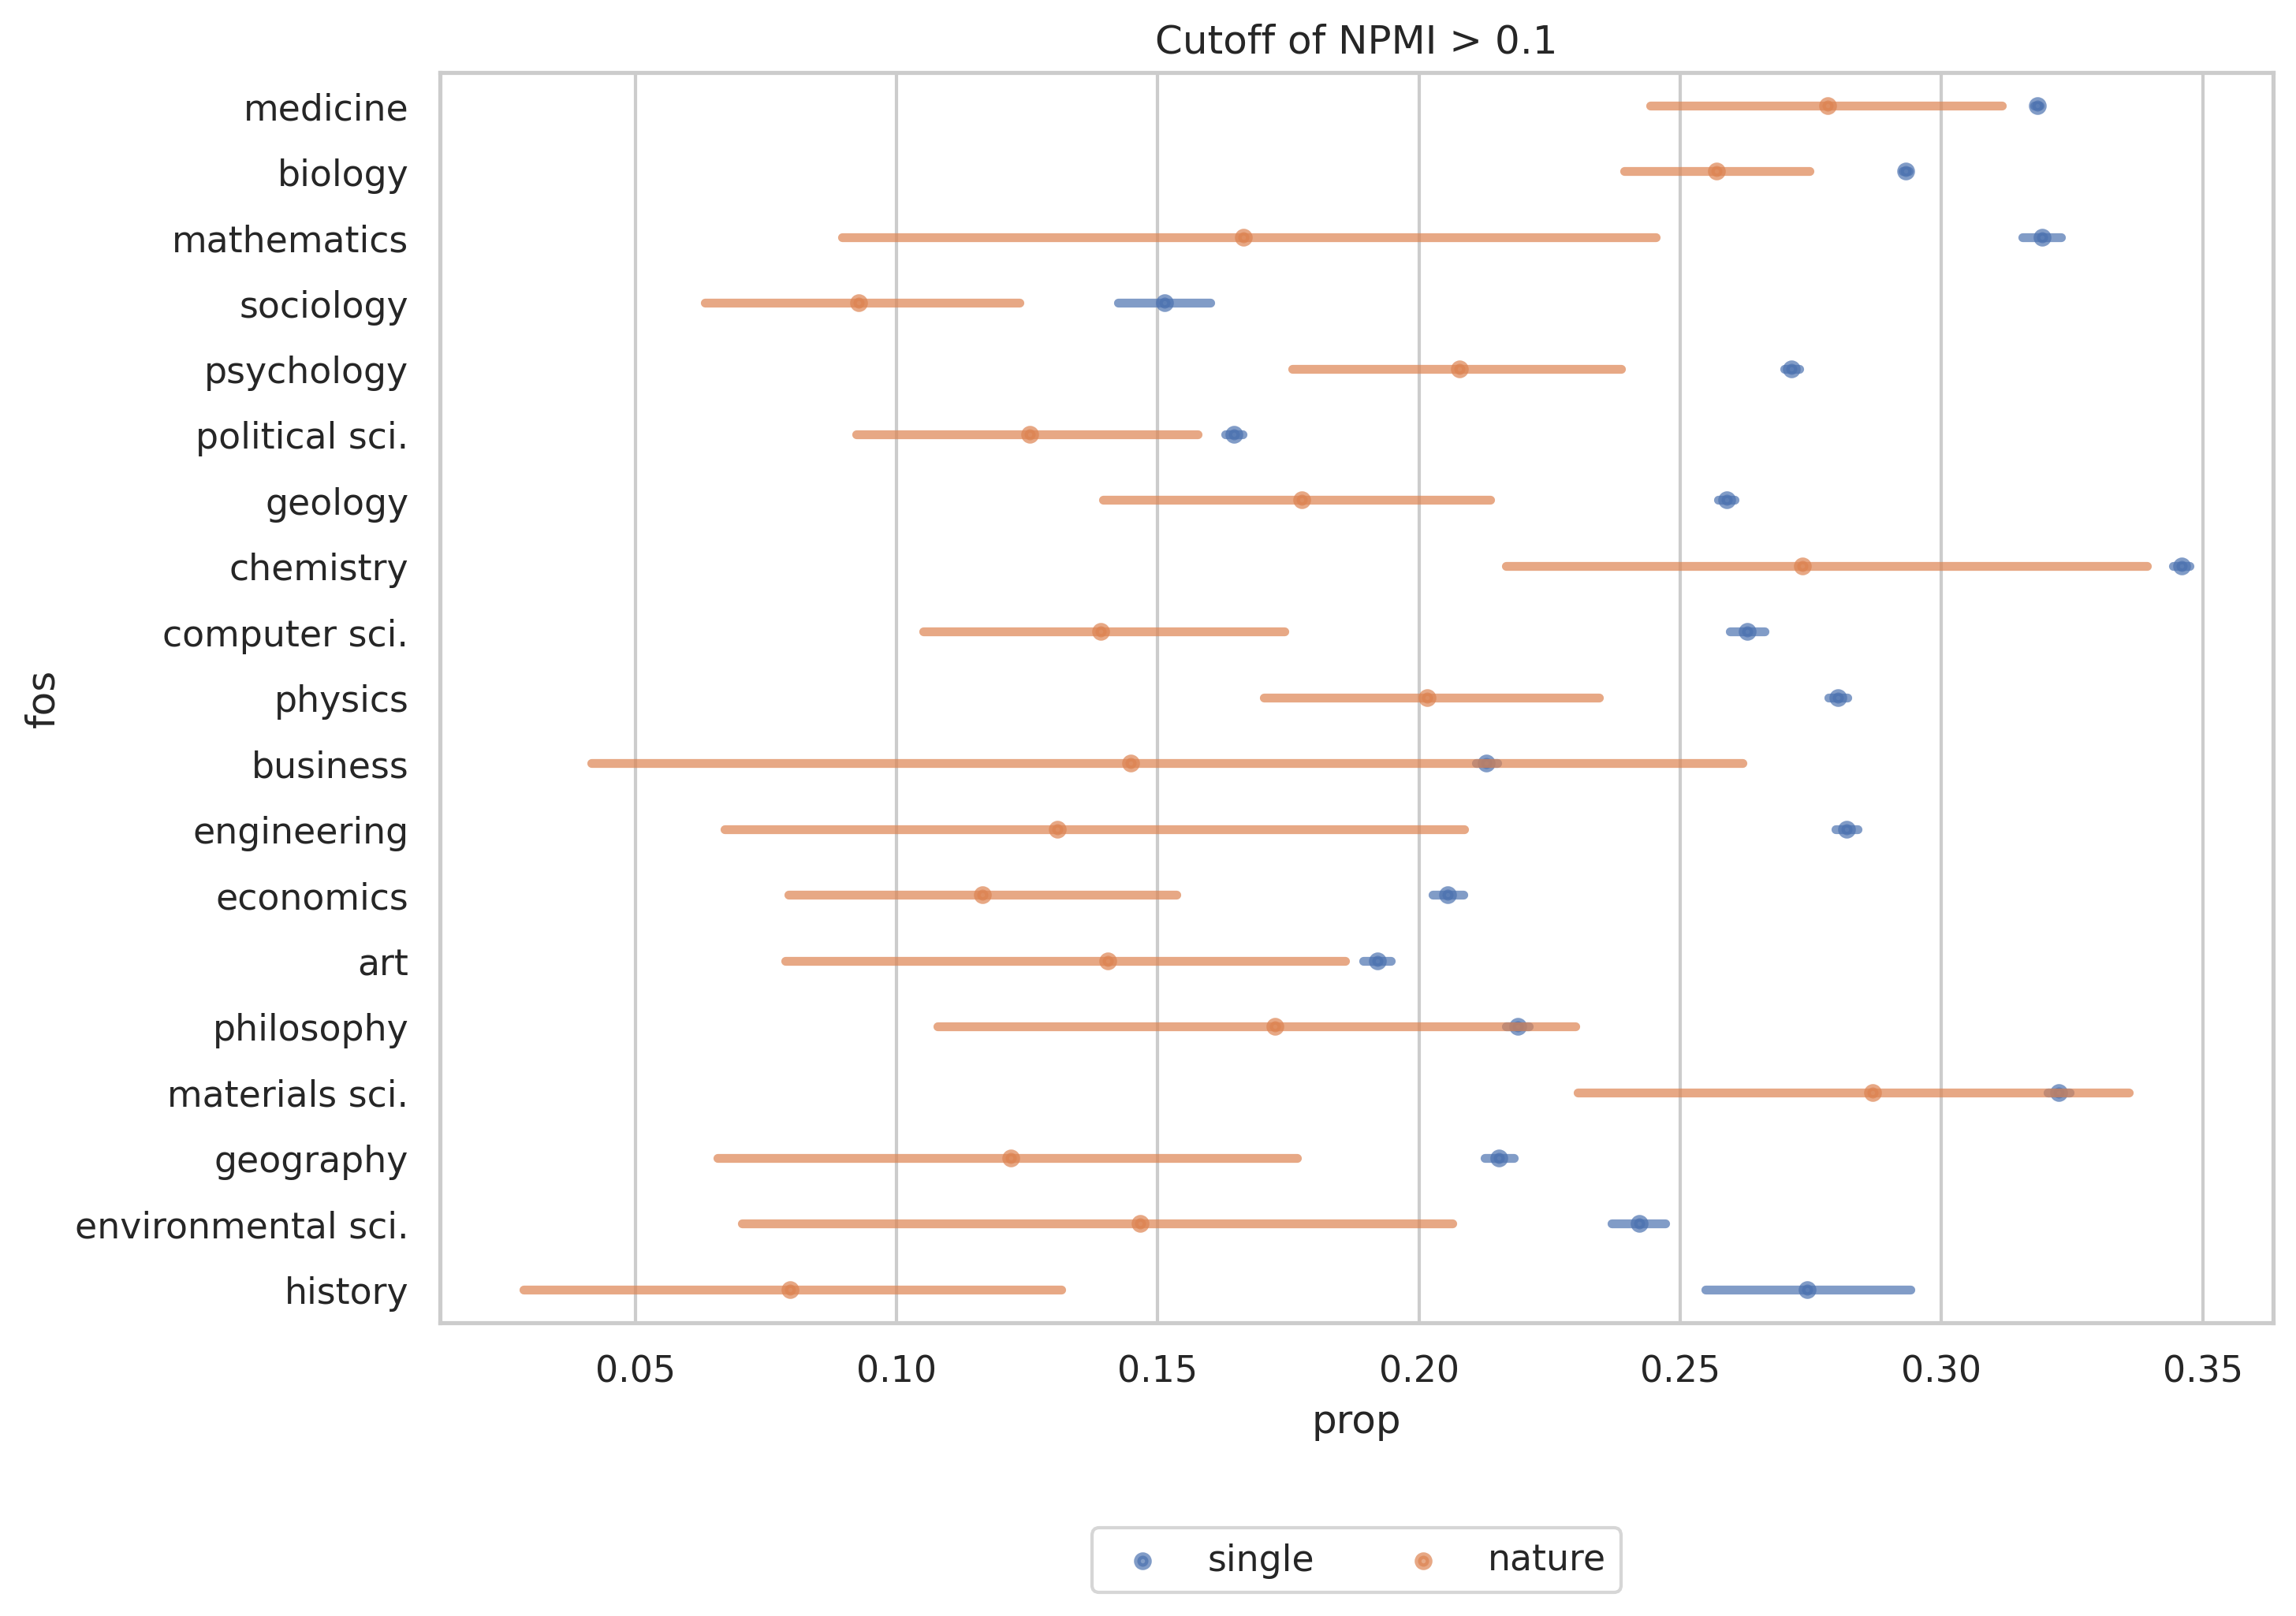

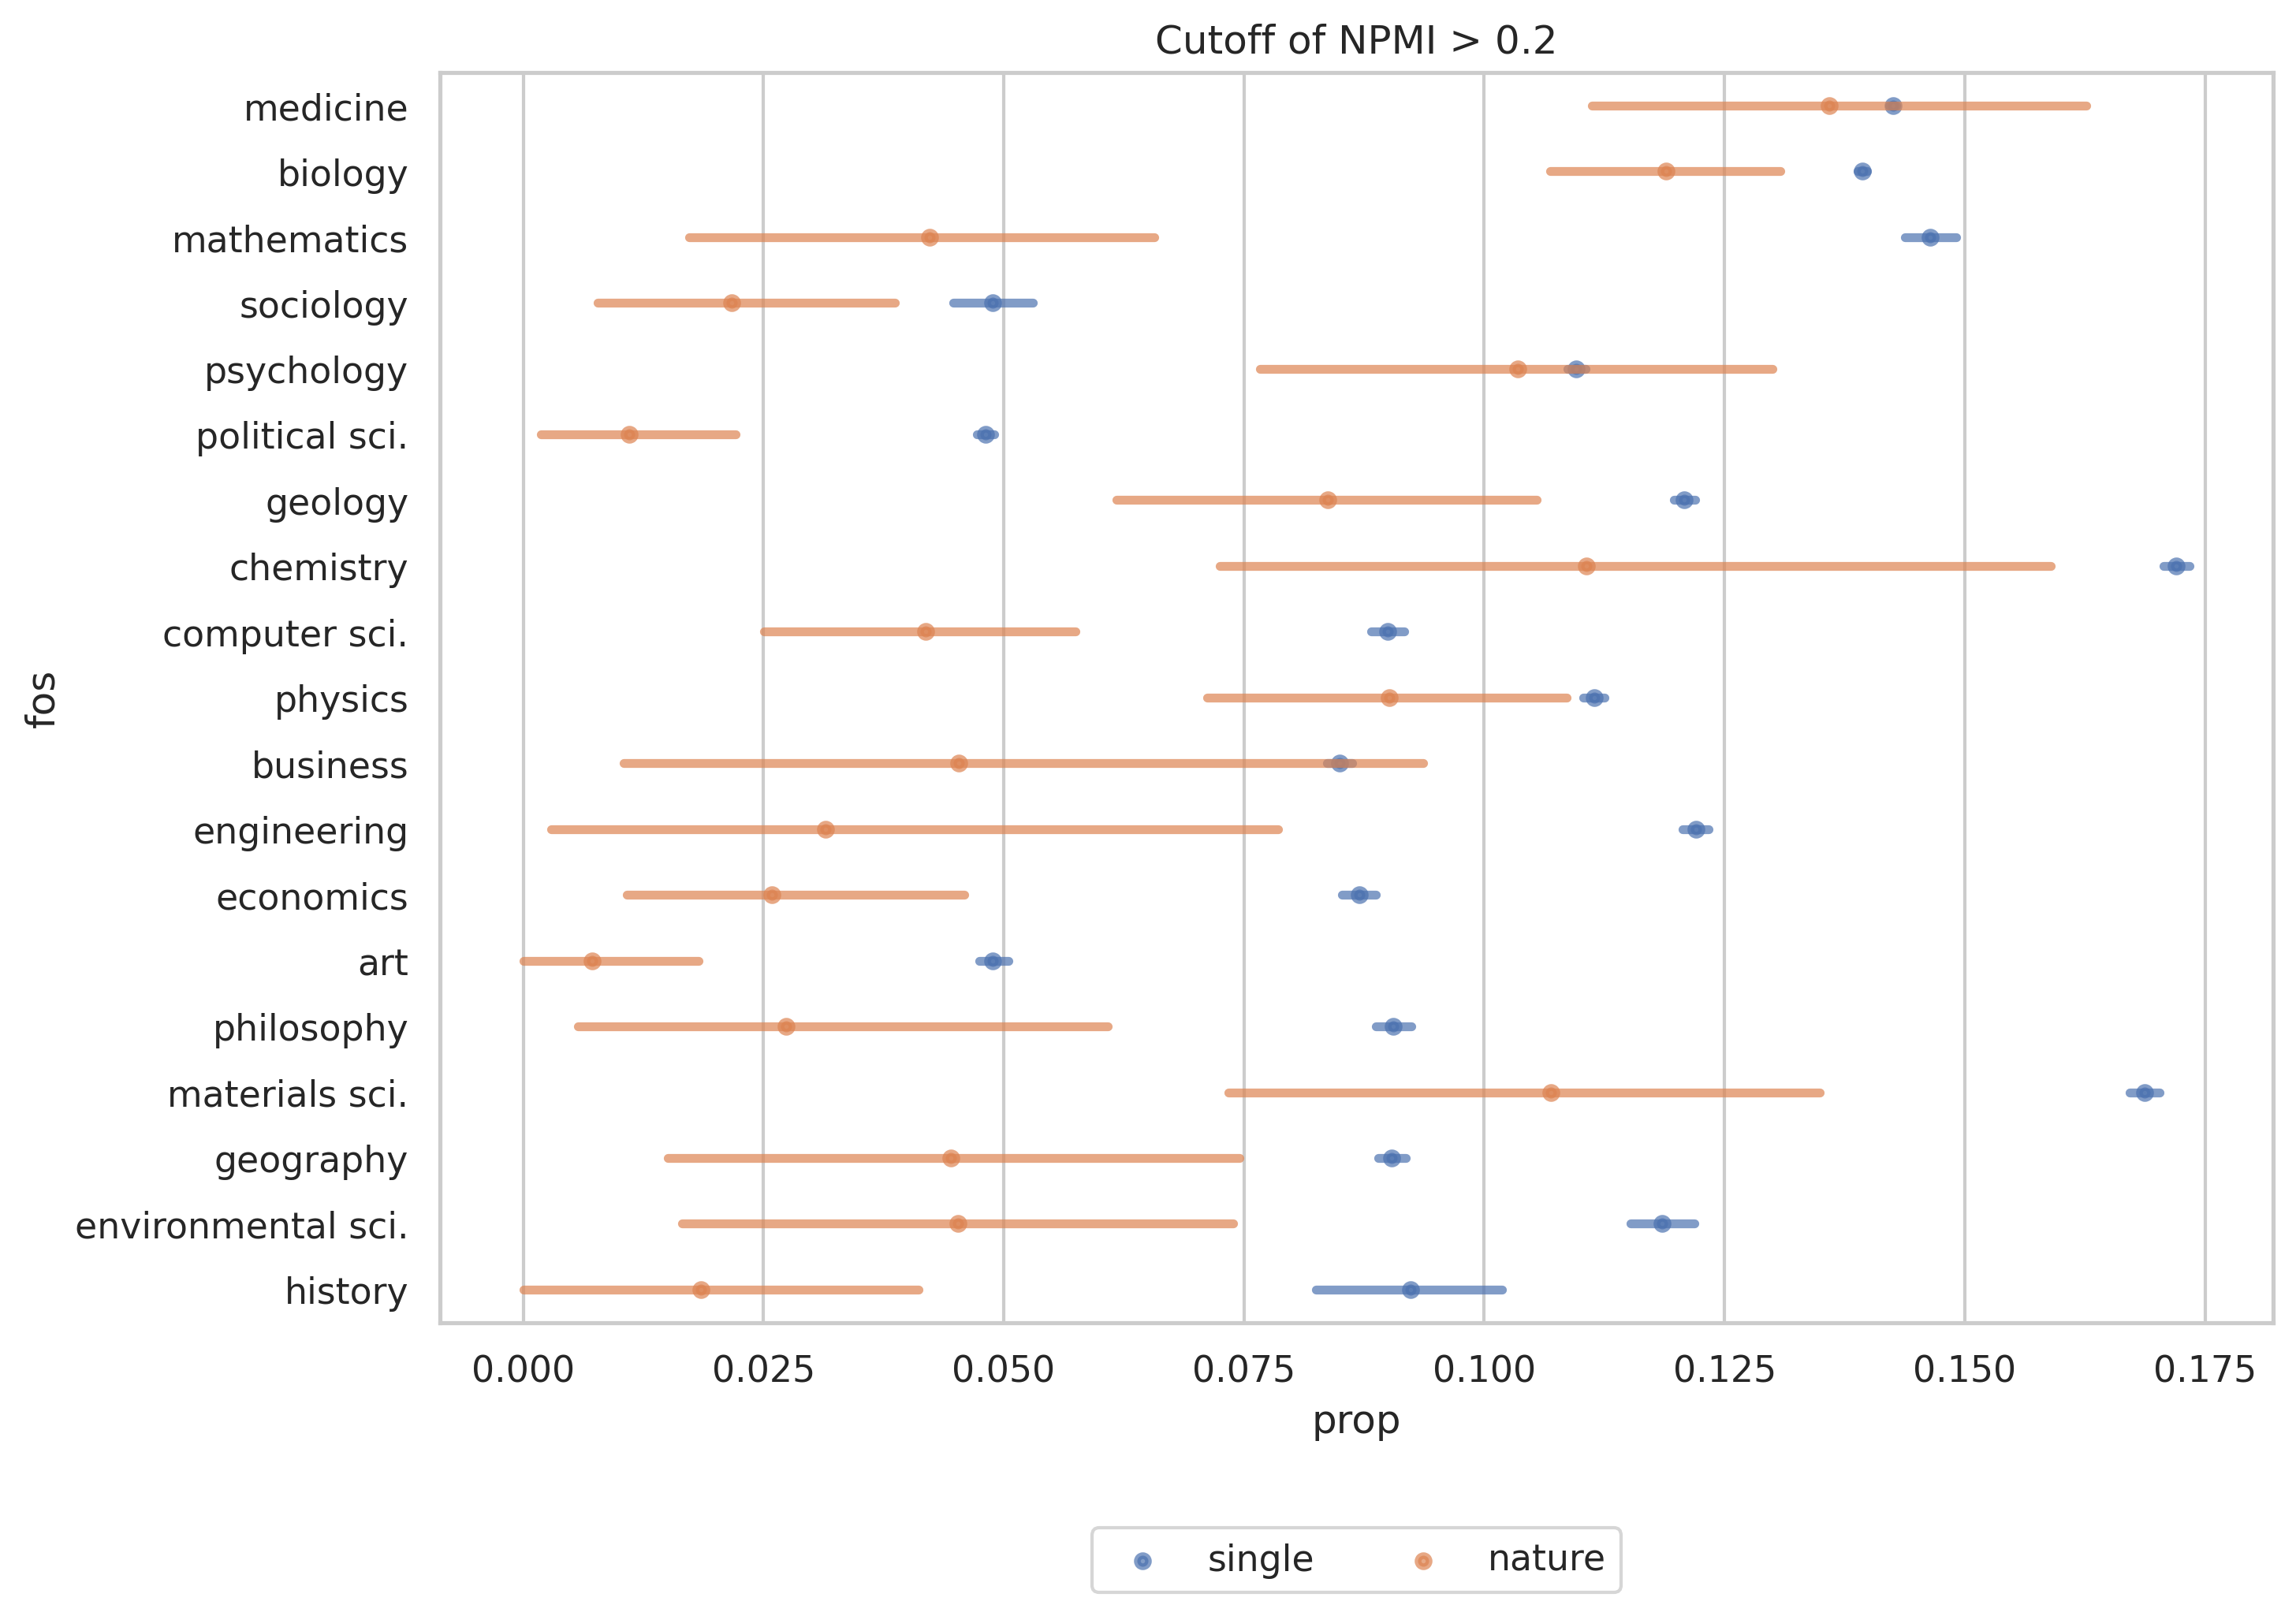

In [47]:
for cutoff in topNfos_df['cutoff'].unique(): 
    this_df = topNfos_df[topNfos_df['cutoff'] == cutoff]
    this_df = this_df[this_df['journal'].isin(['single', 'nature'])]
    order = []
    g = sns.pointplot(data=this_df, x="prop", y="fos", 
                      hue="journal", markers='.', join=False)
    plt.setp(g.collections, alpha=.7) #for the markers
    plt.setp(g.lines, alpha=.7)       #for the lines
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          ncol=3)
    plt.title("Cutoff of NPMI > " + cutoff)
    plt.show()

## Expected max jargon, discipline specific vs. general purpose

In [48]:
expected_max_df = pd.read_parquet(LOGS + 'general_specific/expected_max_of_first_n.parquet')

In [49]:
expected_max_df

,Field,Journal/venue type,cutoff,m,Max NPMI
0,medicine,single,0.1,0,-0.036112
1,biology,single,0.1,0,0.320890
2,mathematics,single,0.1,0,-0.029083
3,sociology,single,0.1,0,-0.002345
4,medicine,single,0.1,0,0.130201
...,...,...,...,...,...
32764195,engineering,single,0.1,99,0.259029
32764196,biology,single,0.1,99,0.321641
32764197,medicine,single,0.1,99,0.321641
32764198,mathematics,single,0.1,99,0.215185


In [50]:
expected_max_df['cutoff'].unique()

array(['0.1'], dtype=object)

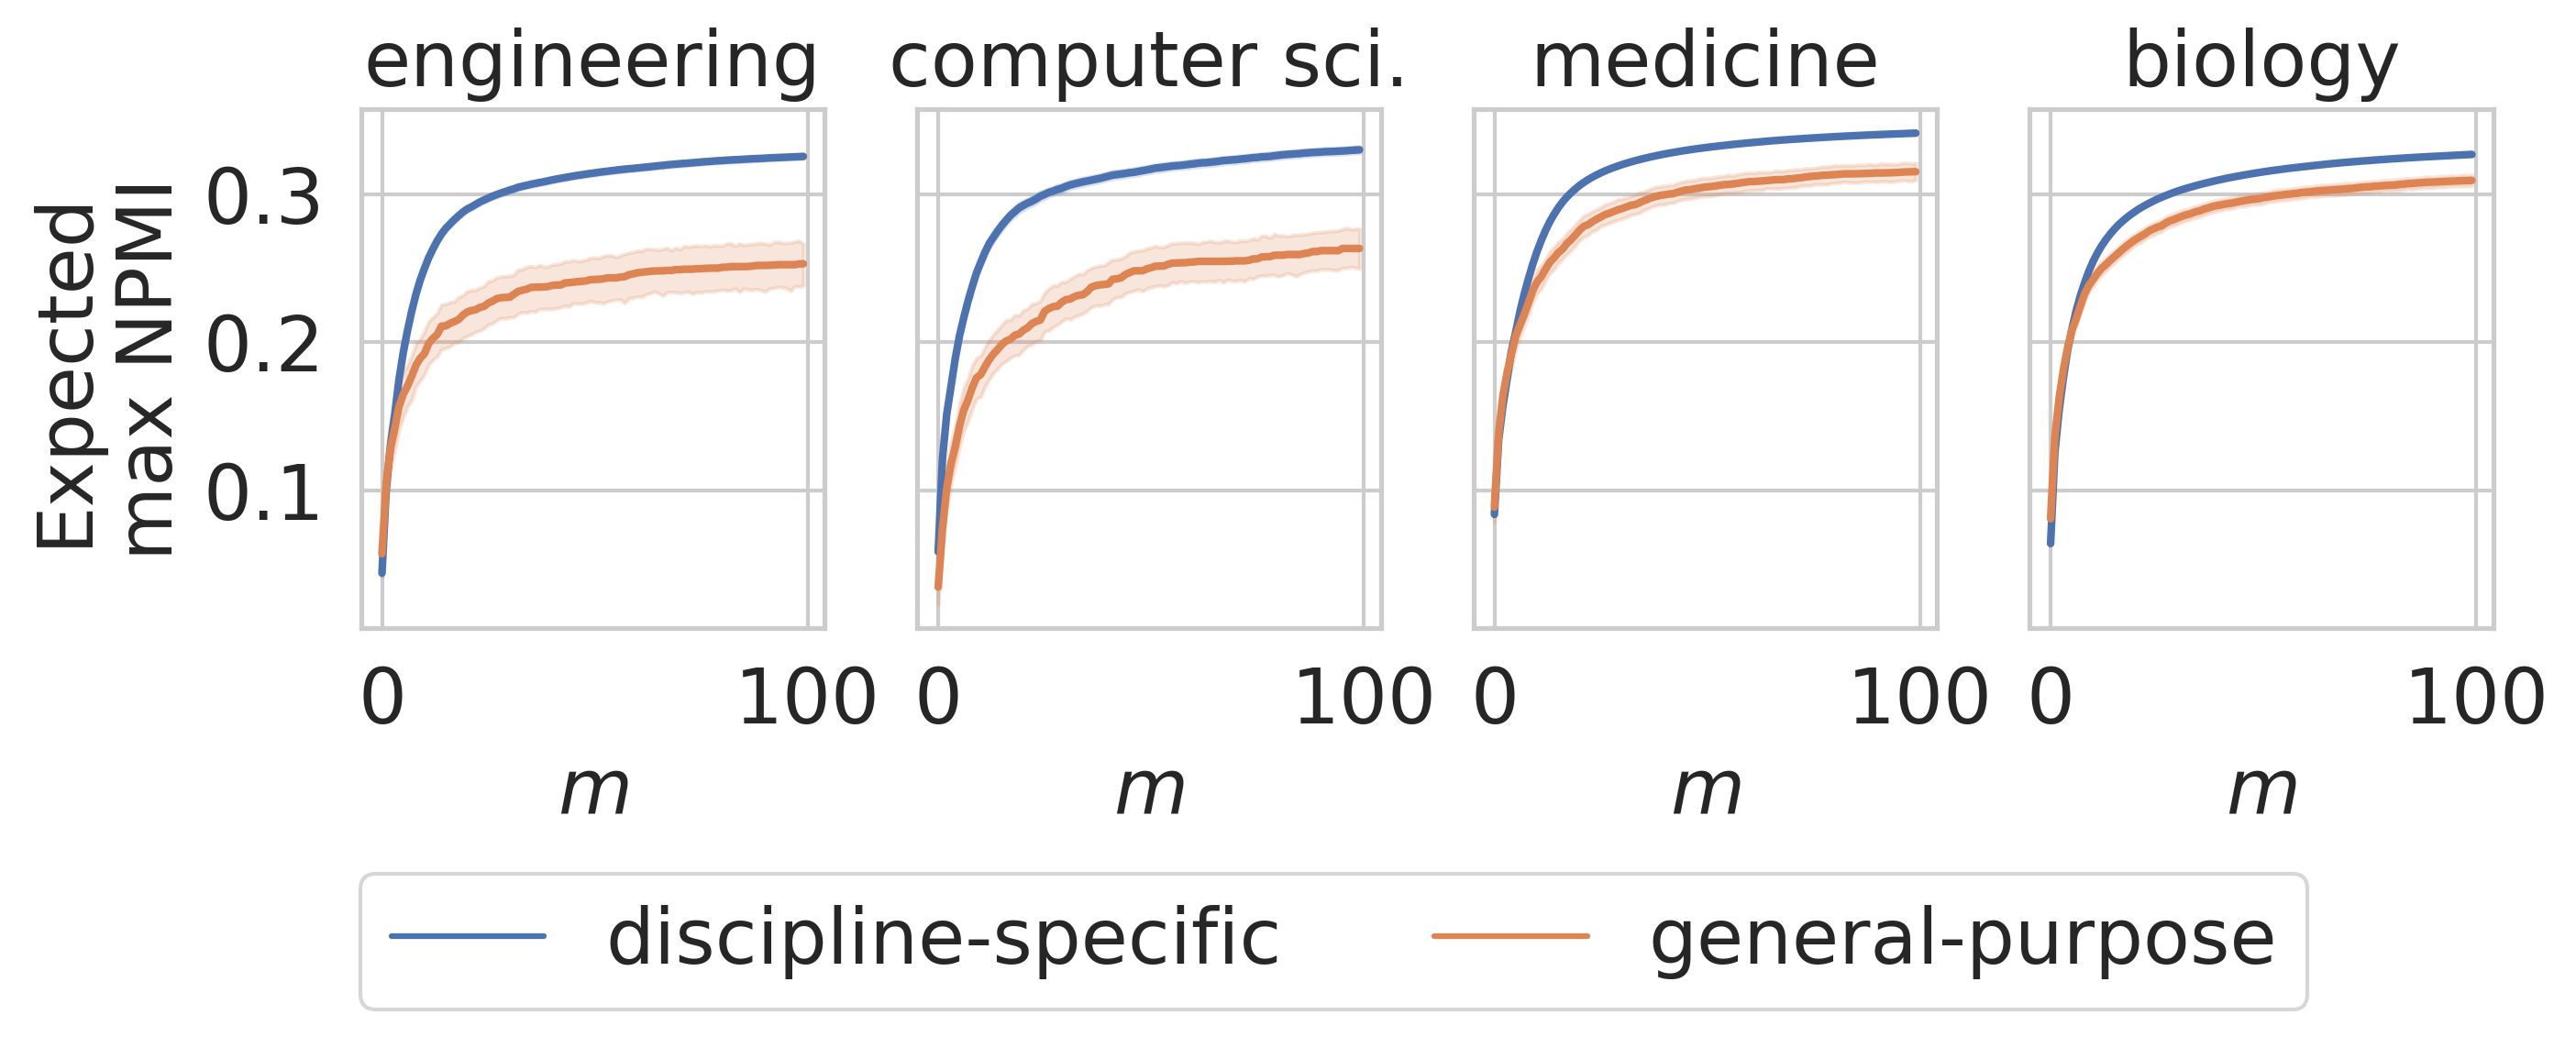

In [51]:
fos_of_interest = ['engineering', 'computer science', 'medicine', 'biology']
fig, axes = plt.subplots(1, len(fos_of_interest), sharey=True, figsize=(10, 2.5))
for i, fos in enumerate(fos_of_interest): 
    this_df = expected_max_df[expected_max_df['Field'] == fos]
    sns.lineplot(data=this_df, x="m", y="Max NPMI", 
                 hue='Journal/venue type', hue_order=['single', 'multi'], 
                 ax=axes[i], linewidth = 2)
    axes[i].set_title(fos.replace('science', 'sci.'), fontsize=20)
    if i == 0:
        axes[i].set_ylabel('Expected\nmax NPMI', fontsize=20)
    if i != len(fos_of_interest)-1: 
        axes[i].get_legend().remove()
    else: 
        handles, labels = axes[i].get_legend_handles_labels()
        axes[i].legend(loc='upper center', bbox_to_anchor=(-1.5, -0.4), handles=handles, ncol=2,
                       labels=['discipline-specific', 'general-purpose'], fontsize=20)
    axes[i].set_xlabel('$m$', fontsize=20)
    axes[i].tick_params(axis='both', which='major', labelsize=20)
plt.show()

## Overall jargon rate in papers across FOS

In [28]:
paper_scores_path = LOGS + 'fos_sample/paper_scores/'

In [29]:
paper_discp = {} 
with open(LOGS + 'wiktionary/s2orc_fos.json', 'r') as infile: 
    s2orc_fos = json.load(infile)

for paper_id in s2orc_fos: 
    if len(s2orc_fos[paper_id]) == 1:
        if 'OTHER ' in s2orc_fos[paper_id][0]: continue
        paper_discp[paper_id] = s2orc_fos[paper_id][0]

In [30]:
result = {
    'cutoff': [], 
    'fos': [], 
    'prop': [], 
}
for cutoff in os.listdir(paper_scores_path): 
    infolder = os.path.join(paper_scores_path, cutoff)
    for f in tqdm(os.listdir(infolder)): 
        with open(os.path.join(infolder, f), 'r') as infile: 
            d = json.load(infile)
        for paper_id in d: 
            for fos in child_to_parents[paper_discp[paper_id]]: 
                result['prop'].append(d[paper_id]['sense'] + d[paper_id]['type'])
                result['cutoff'].append(cutoff)
                result['fos'].append(fos)
            
result_df = pd.DataFrame(data=result)
result_df

100%|██████████| 100/100 [01:14<00:00,  1.34it/s]


,cutoff,fos,prop
0,0.1,medicine,0.362069
1,0.1,medicine,0.405660
2,0.1,chemistry,0.436782
3,0.1,biology,0.190000
4,0.1,chemistry,0.474138
...,...,...,...
12675307,0.1,computer science,0.152778
12675308,0.1,engineering,0.198020
12675309,0.1,engineering,0.253968
12675310,0.1,environmental science,0.145695


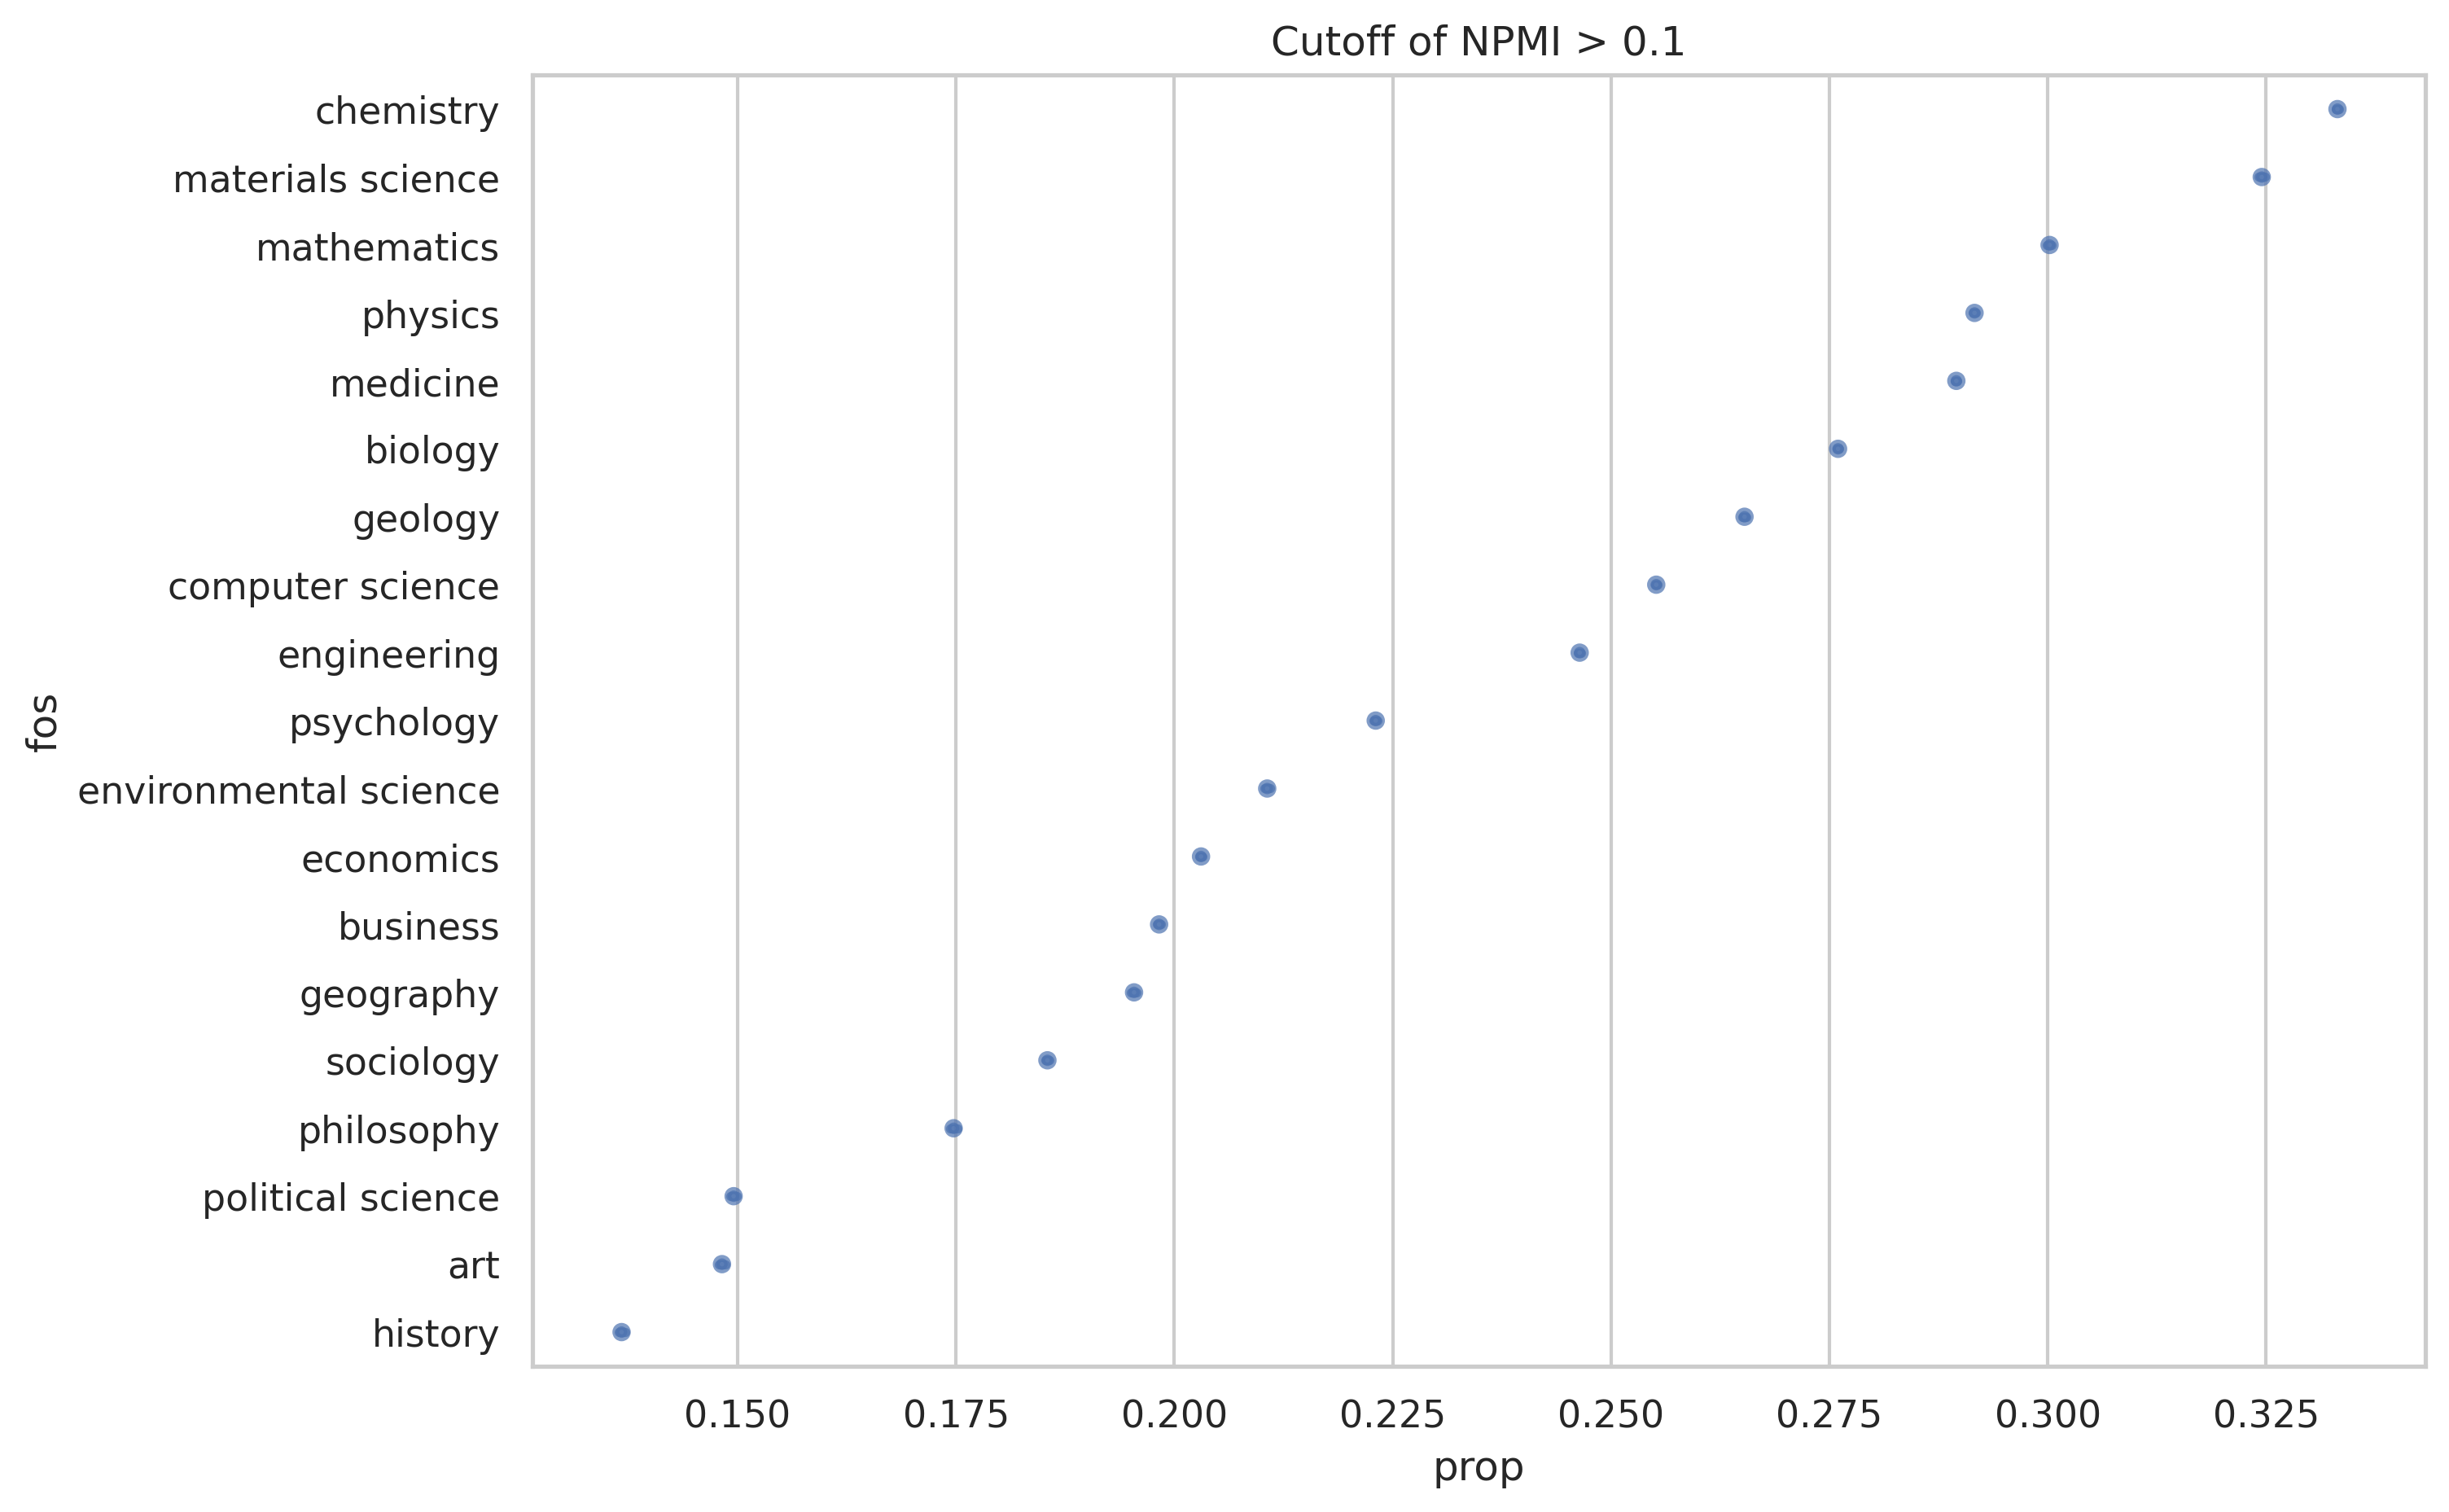

In [31]:
sns.set(rc={"figure.dpi":300})
sns.set_style("whitegrid")
cutoff = "0.1"
this_df = result_df[result_df['cutoff'] == cutoff]
top_level_avg = Counter()
top_level_scores = this_df.groupby('fos')['prop'].apply(list).to_dict()
for parent in top_level_scores: 
    top_level_avg[parent] = np.mean(top_level_scores[parent])
order = []
for tup in top_level_avg.most_common(): 
    order.append(tup[0])
g = sns.pointplot(data=this_df, x="prop", y="fos", markers='.', join=False, order=order)
plt.setp(g.collections, alpha=.7) #for the markers
plt.setp(g.lines, alpha=.7)       #for the lines
plt.title("Cutoff of NPMI > " + cutoff)
plt.show()

## Expected max jargon, across FOS

In [32]:
with open(LOGS + 'fos_sample/expected_max_of_first_n.json', 'r') as infile: 
    expected_max_of_first_n = json.load(infile)

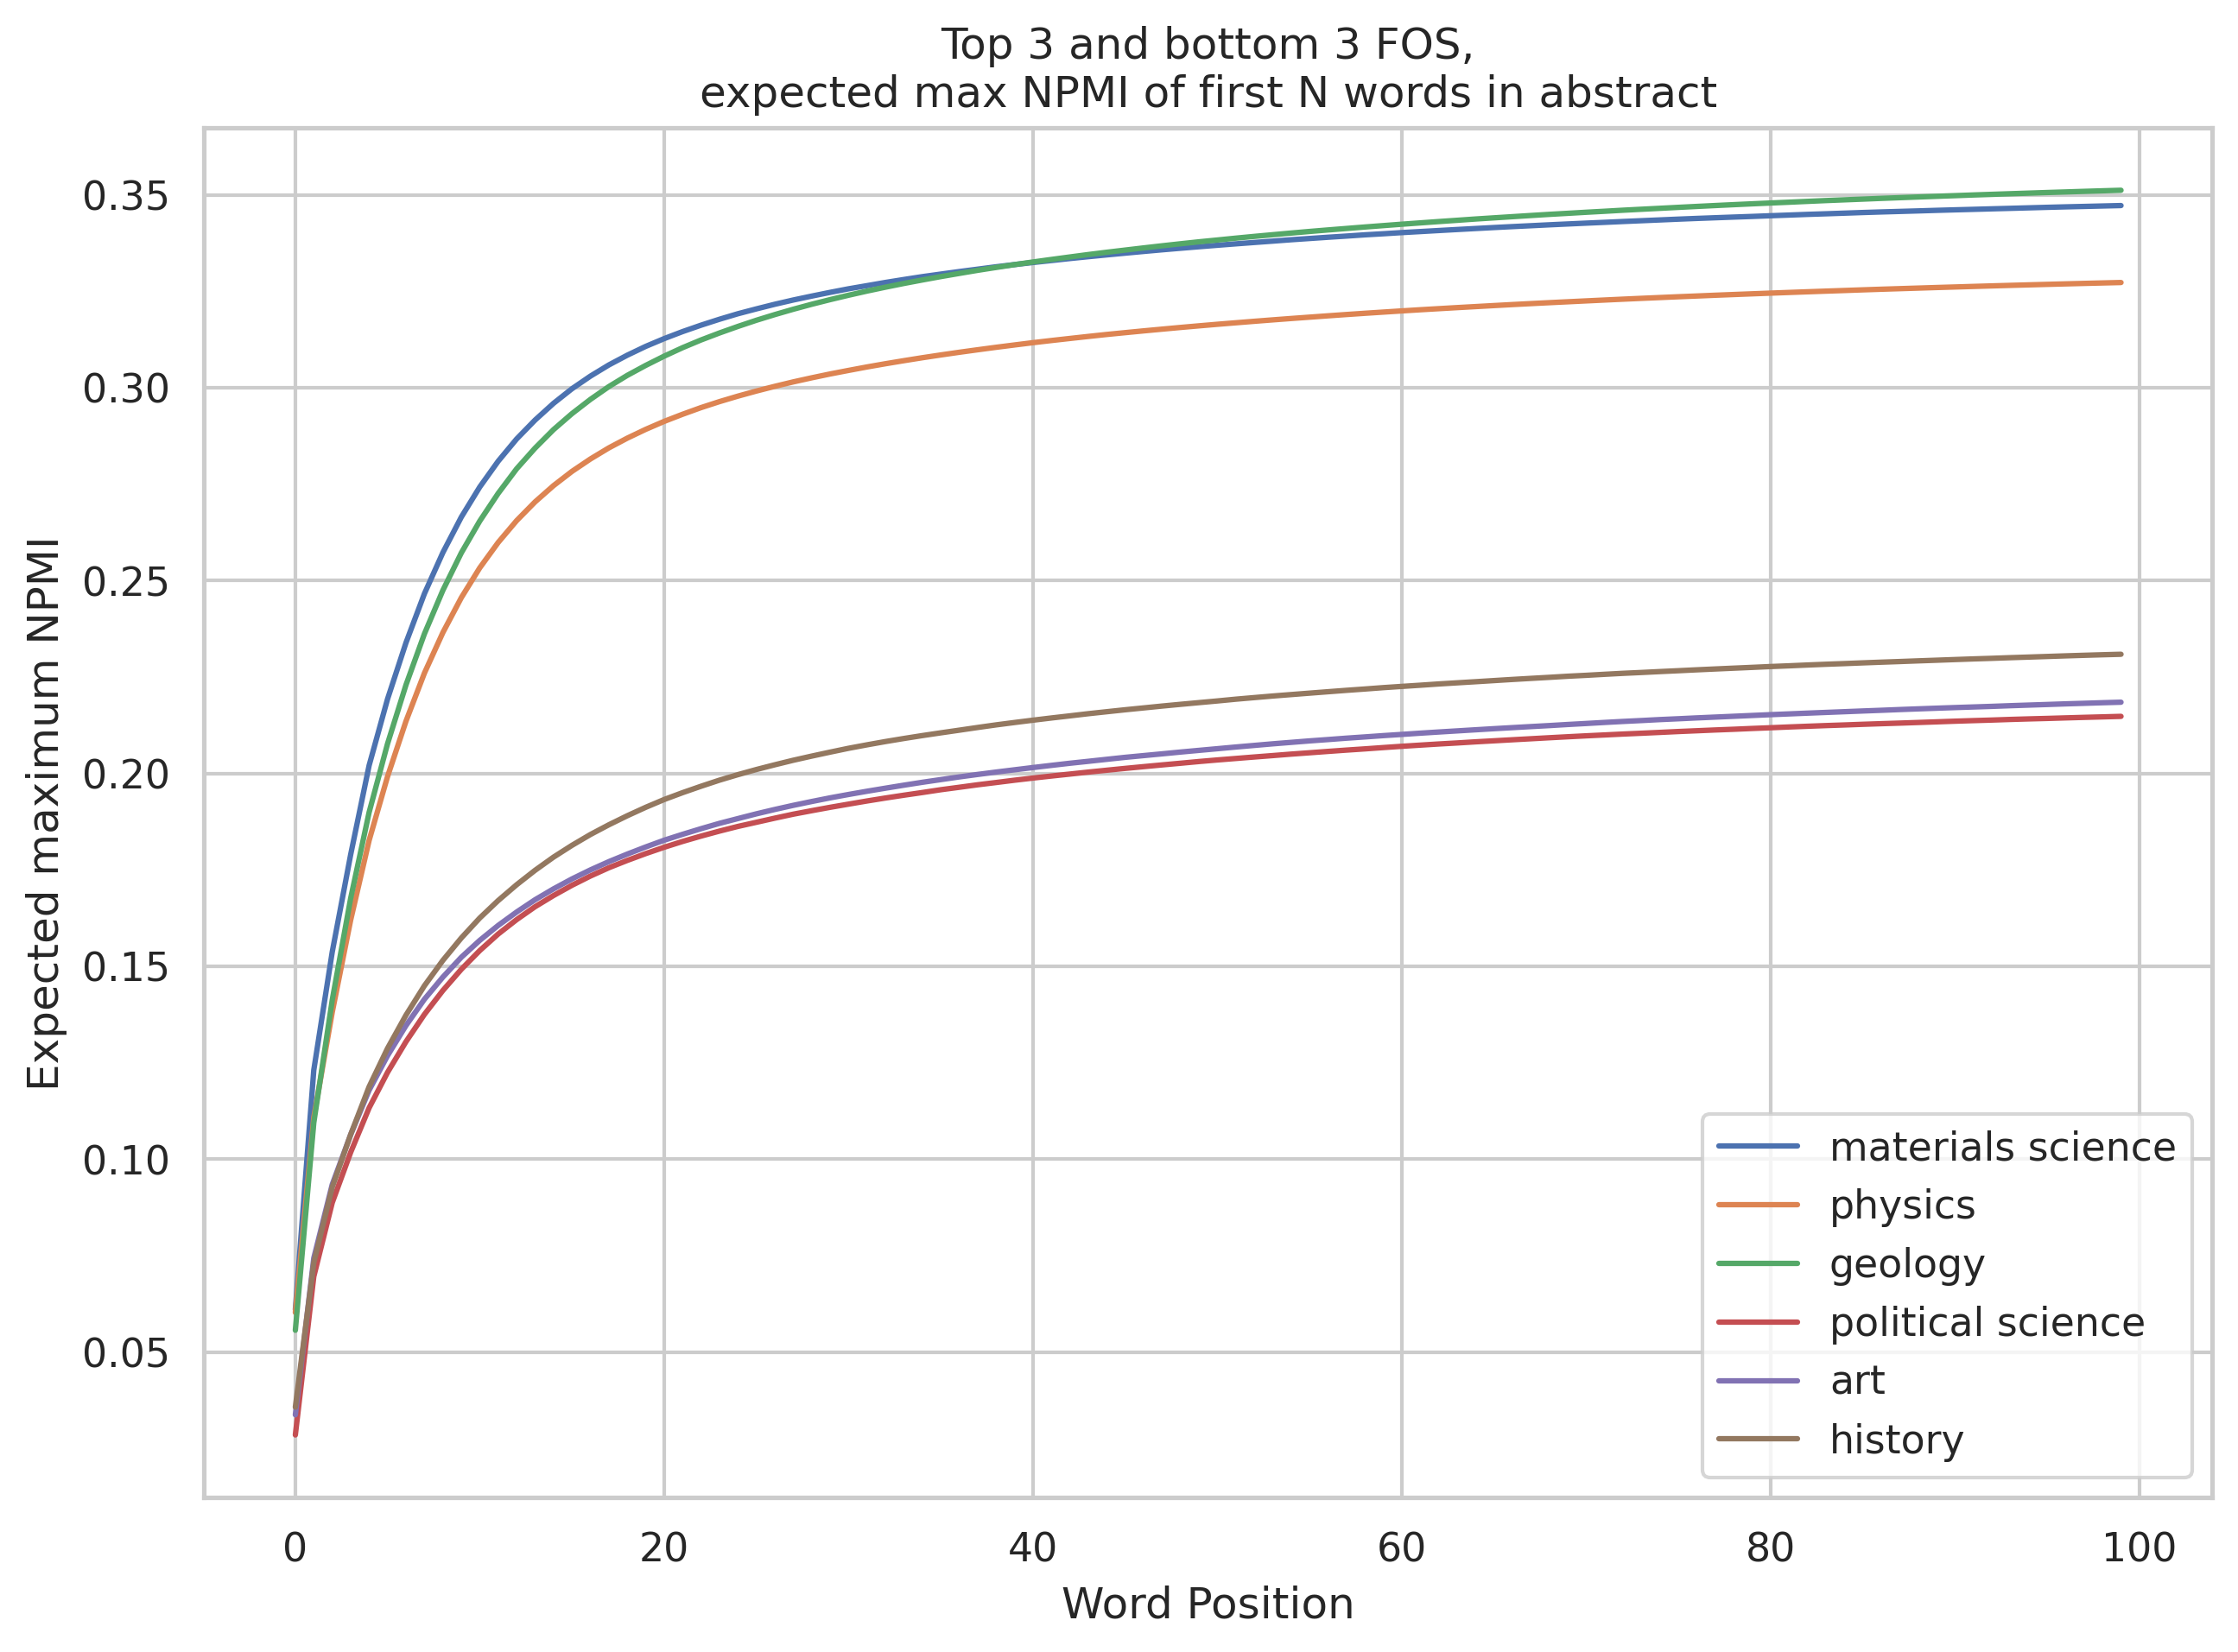

In [33]:
for fos in order: 
    if max(expected_max_of_first_n[fos + '_0.1']) > 0.325 or max(expected_max_of_first_n[fos + '_0.1']) < 0.25:
        plt.plot(range(100), expected_max_of_first_n[fos + '_0.1'], label=fos)
plt.legend()
plt.title("Top 3 and bottom 3 FOS,\nexpected max NPMI of first N words in abstract")
plt.xlabel("Word Position")
plt.ylabel("Expected maximum NPMI")
plt.show()